<a> </a>

# Intro
goal is to fool an already trained model.

https://www.tensorflow.org/tutorials/generative/adversarial_fgsm

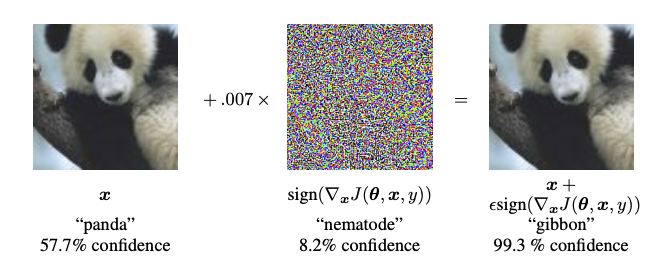

In [2]:
# Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
from google.colab import drive
drive.mount("/content/gdrive")
gdrivepath="/content/gdrive/My Drive/EMLO2/S07_Main/"
import os 
os.chdir(gdrivepath)
!pwd
!ls

Mounted at /content/gdrive
/content/gdrive/My Drive/EMLO2/S07_Main
explain.py	      s07_1_explain.ipynb
imagenet_classes.txt  s07_2_explain_Adveserial_Attacks.ipynb
images		      s07_3_robustness.ipynb
output_1	      setup.py
requirements.txt


In [3]:
%pip install timm captum --quiet

     |████████████████████████████████| 549 kB 26.9 MB/s 
     |████████████████████████████████| 1.4 MB 61.4 MB/s 
     |████████████████████████████████| 182 kB 73.9 MB/s 


In [4]:
import timm
import urllib
import torch

import numpy as np

import torchvision.transforms as T
import torch.nn.functional as F

from PIL import Image

from matplotlib.colors import LinearSegmentedColormap

import matplotlib.pyplot as plt

import os

In [5]:
from captum.robust import FGSM
from captum.robust import PGD

In [6]:
# device = torch.device("cuda")
device = torch.device("cpu")

In [7]:
# Download human-readable labels for ImageNet.
# get the classnames
url, filename = (
    "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt",
    "imagenet_classes.txt",
)
urllib.request.urlretrieve(url, filename)
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

In [8]:
categories

['tench',
 'goldfish',
 'great white shark',
 'tiger shark',
 'hammerhead',
 'electric ray',
 'stingray',
 'cock',
 'hen',
 'ostrich',
 'brambling',
 'goldfinch',
 'house finch',
 'junco',
 'indigo bunting',
 'robin',
 'bulbul',
 'jay',
 'magpie',
 'chickadee',
 'water ouzel',
 'kite',
 'bald eagle',
 'vulture',
 'great grey owl',
 'European fire salamander',
 'common newt',
 'eft',
 'spotted salamander',
 'axolotl',
 'bullfrog',
 'tree frog',
 'tailed frog',
 'loggerhead',
 'leatherback turtle',
 'mud turtle',
 'terrapin',
 'box turtle',
 'banded gecko',
 'common iguana',
 'American chameleon',
 'whiptail',
 'agama',
 'frilled lizard',
 'alligator lizard',
 'Gila monster',
 'green lizard',
 'African chameleon',
 'Komodo dragon',
 'African crocodile',
 'American alligator',
 'triceratops',
 'thunder snake',
 'ringneck snake',
 'hognose snake',
 'green snake',
 'king snake',
 'garter snake',
 'water snake',
 'vine snake',
 'night snake',
 'boa constrictor',
 'rock python',
 'Indian cobr

In [9]:
cat_label = categories.index('Persian cat')

In [10]:
model = timm.create_model("resnet18", pretrained=True) #vgg11 #xception
model.eval()
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [11]:
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(
        mean=mean,
        std=std
    )
])

inv_transform= T.Compose([
    T.Normalize(
        mean = (-1 * np.array(mean) / np.array(std)).tolist(),
        std = (1 / np.array(std)).tolist()
    ),
])

In [20]:
print(gdrivepath)
os.chdir(gdrivepath)

/content/gdrive/My Drive/EMLO2/S07_Main/


In [22]:
img = Image.open('images/1-boat.jpg')

img_tensor = transform(img)
img_tensor = img_tensor.unsqueeze(0)
img_tensor.requires_grad = True
img_tensor = img_tensor.to(device)

In [23]:
def get_prediction(model, image: torch.Tensor):
    model = model.to(device)
    img_tensor = image.to(device)
    with torch.no_grad():
        output = model(img_tensor)
    output = F.softmax(output, dim=1)
    prediction_score, pred_label_idx = torch.topk(output, 1)

    pred_label_idx.squeeze_()
    predicted_label = categories[pred_label_idx.item()]

    return predicted_label, prediction_score.squeeze().item()

In [24]:
def image_show(img, pred):
    npimg = inv_transform(img).squeeze().permute(1, 2, 0).detach().numpy()
    plt.axis('off')
    plt.imshow(npimg)
    plt.title("prediction: %s" % pred)
    plt.show()

In [25]:
pgd = PGD(model, torch.nn.CrossEntropyLoss(reduction='none'), lower_bound=-1, upper_bound=1)  # construct the PGD attacker

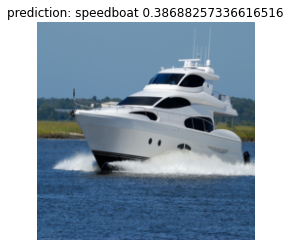

In [26]:
pred, score  = get_prediction(model, img_tensor)
image_show(img_tensor, pred + " " + str(score))

In [27]:
perturbed_image_pgd = pgd.perturb(inputs=img_tensor, radius=0.13, step_size=0.02, 
                                  step_num=7, target=torch.tensor([cat_label]).to(device), targeted=True) 
new_pred_pgd, score_pgd = get_prediction(model, perturbed_image_pgd)

/usr/local/lib/python3.8/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


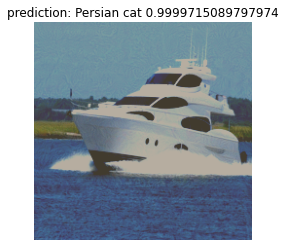

In [28]:
image_show(perturbed_image_pgd.cpu(), new_pred_pgd + " " + str(score_pgd))

In [35]:
def get_adveserial_image(img_path, new_pred_class):
    
    img = Image.open(img_path)

    img_tensor = transform(img)
    img_tensor = img_tensor.unsqueeze(0)
    img_tensor.requires_grad = True
    img_tensor = img_tensor.to(device)

    perturbed_image_pgd = pgd.perturb(inputs=img_tensor, radius=0.13, step_size=0.02, 
                                  step_num=7, target=torch.tensor([new_pred_class]).to(device), targeted=True) 
    new_pred_pgd, score_pgd = get_prediction(model, perturbed_image_pgd)
    
    image_show(perturbed_image_pgd.cpu(), new_pred_pgd + " " + str(score_pgd))

    return perturbed_image_pgd

*------------------------------------------*
output_2/1-boat_adv.jpg


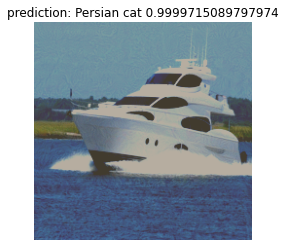

*------------------------------------------*
*------------------------------------------*
output_2/2-car_adv.jpg


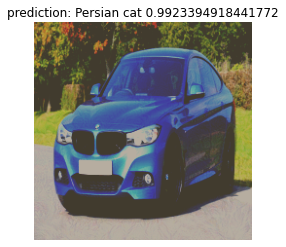

*------------------------------------------*
*------------------------------------------*
output_2/3-cat_adv.jpg


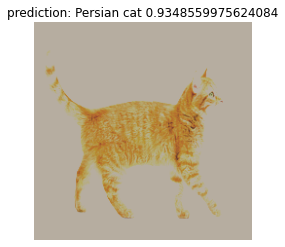

*------------------------------------------*
*------------------------------------------*
output_2/4-dog_adv.jpg


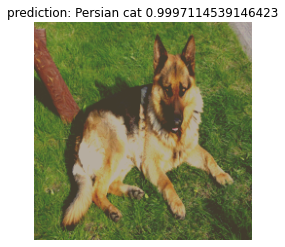

*------------------------------------------*
*------------------------------------------*
output_2/5-bus_adv.jpg


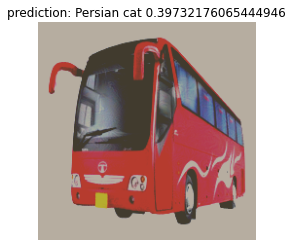

*------------------------------------------*
*------------------------------------------*
output_2/6-truck_adv.jpg


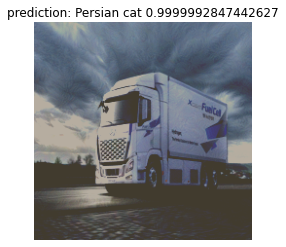

*------------------------------------------*
*------------------------------------------*
output_2/7-tiger_adv.jpg


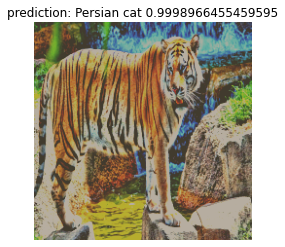

*------------------------------------------*
*------------------------------------------*
output_2/8-shark_adv.jpg


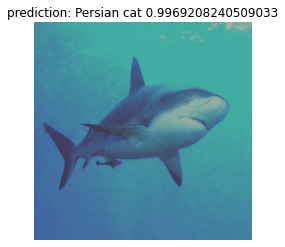

*------------------------------------------*
*------------------------------------------*
output_2/9-turtle_adv.jpg


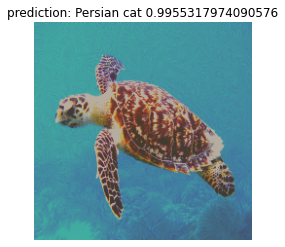

*------------------------------------------*
*------------------------------------------*
output_2/10-alligator_adv.jpg


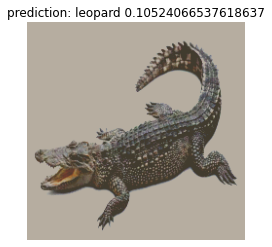

*------------------------------------------*


In [36]:
for img_name in os.listdir('images'):
    img_path = "images/"+img_name
    #---------
    path_list = img_path.split(os.sep)
    filname=path_list[1]
    #print (path_list)
    print("*------------------------------------------*")
    out_img_path = "output_2/"+filname[:filname.rfind(".")] + "_adv" + ".jpg"
    print(out_img_path)
    
    # out_img_path = img_name[:img_name.rfind(".")] + "_adv" + ".jpg"
    
    adv_img = get_adveserial_image(img_path, cat_label)
    piltransform = T.ToPILImage()
    
    piltransform(inv_transform(adv_img).squeeze()).save(out_img_path)
    print("*------------------------------------------*")    